In [72]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Merge Data

In [73]:
def merge_and_deduplicate_data(file_paths, output_filename=None):
    """
    ฟังก์ชันสำหรับรวมไฟล์ CSV หลายไฟล์เข้าด้วยกันและตัดข้อมูลซ้ำโดยใช้ 'id'
    
    Args:
        file_paths (list): รายชื่อ path ของไฟล์ .csv ที่ต้องการรวม
                           เช่น ['data_part1.csv', 'data_part2.csv']
        output_filename (str, optional): ชื่อไฟล์ปลายทางถ้าต้องการบันทึกเป็น CSV ทันที
    
    Returns:
        pd.DataFrame: DataFrame ที่รวมและตัดตัวซ้ำเรียบร้อยแล้ว
    """
    
    all_dfs = []
    
    print(f"--- Starting Merge Process ---")
    
    # 1. วนลูปอ่านไฟล์แต่ละไฟล์ (Read CSVs)
    for file in file_paths:
        if os.path.exists(file):
            try:
                # อ่านไฟล์ CSV เข้ามาเป็น DataFrame
                df = pd.read_csv(file)
                all_dfs.append(df)
                print(f"[READ] {file}: Found {len(df)} rows")
            except Exception as e:
                print(f"[ERROR] Could not read {file}: {e}")
        else:
            print(f"[SKIP] File not found: {file}")
    
    if not all_dfs:
        print("No data loaded.")
        return pd.DataFrame()

    # 2. รวม DataFrame ทั้งหมดเข้าด้วยกัน (Concatenation)
    merged_df = pd.concat(all_dfs, ignore_index=True)
    total_rows_before = len(merged_df)
    
    # 3. ตัดข้อมูลซ้ำโดยดูจาก 'id' (Deduplication)
    # keep='last' หมายถึงถ้าเจอ id ซ้ำกัน ให้เก็บข้อมูลตัวล่าสุดไว้ (สมมติว่าเป็นข้อมูลที่อัปเดตกว่า)
    # subset=['id'] คือระบุว่าให้ดูความซ้ำกันที่คอลัมน์ id เท่านั้น
    cleaned_df = merged_df.drop_duplicates(subset=['id'], keep='last')
    
    total_rows_after = len(cleaned_df)
    duplicates_removed = total_rows_before - total_rows_after
    
    print(f"--- Merge Summary ---")
    print(f"Total rows raw: {total_rows_before}")
    print(f"Duplicates removed: {duplicates_removed}")
    print(f"Final unique rows: {total_rows_after}")
    
    # 4. รีเซ็ต index ให้เรียงสวยงาม 0, 1, 2, ...
    cleaned_df = cleaned_df.reset_index(drop=True)
    
    # 5. บันทึกไฟล์ถ้ามีการระบุชื่อไฟล์ (Export)
    if output_filename:
        cleaned_df.to_csv(output_filename, index=False, encoding='utf-8-sig')
        print(f"[SAVED] Merged data saved to: {output_filename}")
        
    return cleaned_df

## Log data

In [74]:
def log_data_stats(df, column_name):
    """
    ฟังก์ชันสำหรับวิเคราะห์สถิติและพล็อตกราฟ
    
    Args:
        df (pd.DataFrame): DataFrame หลัก
        column_name (str): ชื่อคอลัมน์ที่ต้องการวิเคราะห์ (Default: 'salary_amount')
    """
    
    print("\n" + "="*40)
    print(f"         STATISTICS LOG for '{column_name}'          ")
    print("="*40)
    
    # 1. เตรียมข้อมูล (Data Preparation)
    # แปลงเป็นตัวเลข (เผื่อเป็น string) และลบค่าว่าง (NaN) หรือค่า 0 ออกเพื่อความแม่นยำ
    if column_name not in df.columns:
        print(f"[ERROR] Column '{column_name}' not found.")
        return

    # coerce จะเปลี่ยน text ที่แปลงไม่ได้เป็น NaN
    data_numeric = pd.to_numeric(df[column_name], errors='coerce') 
    # กรองเอาเฉพาะที่มีค่าและมากกว่า 0 (บางที่ใส่ 0 หมายถึงไม่ระบุ)
    valid = data_numeric.dropna()
    valid = valid[valid > 0]
    
    if len(valid) == 0:
        print("No valid data found (all are NaN or 0).")
        return

    # 2. คำนวณสถิติ (Calculation)
    min = valid.min()
    max = valid.max()
    mean = valid.mean()
    
    # Mode อาจมีหลายค่าถ้าความถี่เท่ากัน
    modes = valid.mode()
    mode_str = ", ".join(map(str, modes.tolist()))
    
    # คำนวณ IQR (Interquartile Range)
    q1 = valid.quantile(0.25)
    q3 = valid.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # 3. แสดงผล Log (Logging)
    print(f"Count (Valid): {len(valid)} positions")
    print("-" * 40)
    print(f"Min   : {min:,.2f}")
    print(f"Max   : {max:,.2f}")
    print(f"Mean  : {mean:,.2f}")
    print(f"Mode  : {mode_str}")
    print("-" * 40)
    print("--- Variability (IQR) ---")
    print(f"Q1 (25%)     : {q1:,.2f}")
    print(f"Q3 (75%)     : {q3:,.2f}")
    print(f"IQR Value    : {iqr:,.2f}")
    print(f"Lower bound : Q1 - 1.5*IQR : {lower_bound:,.2f}")
    print(f"Upper bound : Q3 + 1.5*IQR : {upper_bound:,.2f}")
    print("="*40 + "\n")

    # 4. สร้างกราฟ (Visualization)
    # ตั้งค่า font ให้สวยงาม (ถ้ามีปัญหาภาษาไทยให้เอา font property ออกหรือเปลี่ยนเป็น Tahoma)
    plt.figure(figsize=(12, 5))
    
    # Subplot 1: Histogram + KDE (การกระจายตัว)
    plt.subplot(1, 2, 1)
    sns.histplot(valid, kde=True, color='skyblue', bins=20)
    plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.0f}')
    plt.axvline(valid.median(), color='green', linestyle='-', label=f'Median: {valid.median():.0f}')
    plt.title(f'Distribution of {column_name} Amount')
    plt.xlabel(f'{column_name} (THB)')
    plt.ylabel('Frequency')
    plt.legend()

    # Subplot 2: Boxplot (ดู IQR และ Outliers)
    plt.subplot(1, 2, 2)
    sns.boxplot(x=valid, color='lightgreen')
    plt.title(f'Boxplot of {column_name} (IQR & Outliers)')
    plt.xlabel(f'{column_name} (THB)')
    
    plt.tight_layout()
    plt.show()

## Main

In [95]:
# สมมติว่าเรามีไฟล์ csv 2 ไฟล์ที่ได้จากการ scrape
files_to_merge = [
    "cedt_intern_data_1000_2000.csv",  # ไฟล์จากวิธี loop ID
    "cedt_intern_data_paginated13.csv"   # ไฟล์จากวิธี pagination
]

# merge และ deduplicate ข้อมูล
df = merge_and_deduplicate_data(files_to_merge, "cedt_intern_all_merged.csv")

# create student_draft_ratio column
df['inStudentDraftCount'] = df['inStudentDraftCount'].fillna(0)
df['quota'] = df['quota'].fillna(1)  # เติม 1 เพื่อหลีกเลี่ยงการหารด้วยศูนย์
df['student_draft_ratio'] = df['inStudentDraftCount']/df['quota']

print("Salary type" + "*" *60)
print(df['salary_type'].value_counts())
mask = df['salary_type'].str.contains('บาท/เดือน', na=False, case=False)
df.loc[mask, 'salary_amount'] = df.loc[mask, 'salary_amount'] / 22
df.loc[mask, 'salary_amount'] = df.loc[mask, 'salary_amount'].round(0)

--- Starting Merge Process ---
[READ] cedt_intern_data_1000_2000.csv: Found 125 rows
[READ] cedt_intern_data_paginated13.csv: Found 218 rows
--- Merge Summary ---
Total rows raw: 343
Duplicates removed: 137
Final unique rows: 206
[SAVED] Merged data saved to: cedt_intern_all_merged.csv
Salary type************************************************************
salary_type
บาท/วัน           94
ไม่มีค่าตอบแทน    17
บาท/เดือน         15
บาท (เหมาจ่าย)     1
Name: count, dtype: int64


In [96]:
# df.head()
# df['work_type'].value_counts()
df.describe(include="all")

,id,company_name,position_title,quota,salary_amount,salary_type,work_type,location,tags,description_html,api_url,company_nameTh,company_nameEn,Start Date,End Date,inStudentDraftCount,student_draft_ratio
count,206.000000,0,206,206.000000,117.000000,127,184,206,165,201,206,206,206,86,86,206.000000,206.000000
unique,NaN,0,172,NaN,NaN,4,3,68,154,198,11,82,82,14,10,NaN,NaN
top,NaN,NaN,Data Engineer,NaN,NaN,บาท/วัน,Hybrid,สำนักงานใหญ่,"UX/UI, Software Engineer, Intern, JavaScript, ...",<h2><strong>About the Project</strong></h2><p>...,https://cedtintern.cp.eng.chula.ac.th/api/sess...,บริษัท เจริญโภคภัณฑ์อาหาร จำกัด (มหาชน),CPF,2026-04-30T17:00:00.000Z,2026-07-30T17:00:00.000Z,NaN,NaN
freq,NaN,NaN,8,NaN,NaN,94,100,55,4,3,20,11,11,25,51,NaN,NaN
mean,1309.266990,NaN,NaN,2.451456,336.162393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.373786,2.090927
std,137.280598,NaN,NaN,2.863577,147.768806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.992810,2.427746
min,1039.000000,NaN,NaN,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,1191.250000,NaN,NaN,1.000000,300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250000,0.008333
50%,1322.500000,NaN,NaN,1.000000,400.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,1.000000
75%,1434.750000,NaN,NaN,3.000000,450.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,3.000000


Position Title Counts:************************************************************
position_title
Data Engineer                                      8
Business Analyst                                   6
Software Developer                                 6
Full Stack Developer                               4
Software Engineer                                  4
                                                  ..
Full Stack Engineer                                1
Cybersecurity Analyst                              1
Technology Analyst Intern (IP Managaement Team)    1
Full Stack Developer Intern                        1
Software Engineer (Platform)                       1
Name: count, Length: 172, dtype: int64
Ratio Student Draft:************************************************************

         STATISTICS LOG for 'student_draft_ratio'          
Count (Valid): 154 positions
----------------------------------------
Min   : 0.03
Max   : 11.00
Mean  : 2.80
Mode  : 1.0
----------------

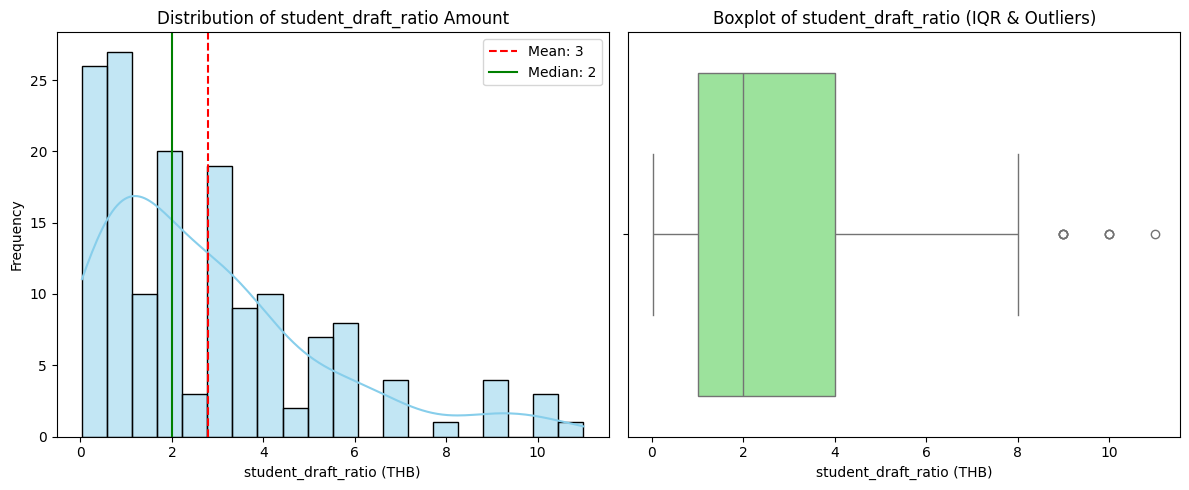

Salary:************************************************************

         STATISTICS LOG for 'salary_amount'          
Count (Valid): 105 positions
----------------------------------------
Min   : 100.00
Max   : 600.00
Mean  : 374.58
Mode  : 400.0
----------------------------------------
--- Variability (IQR) ---
Q1 (25%)     : 300.00
Q3 (75%)     : 450.00
IQR Value    : 150.00
Lower bound : Q1 - 1.5*IQR : 75.00
Upper bound : Q3 + 1.5*IQR : 675.00



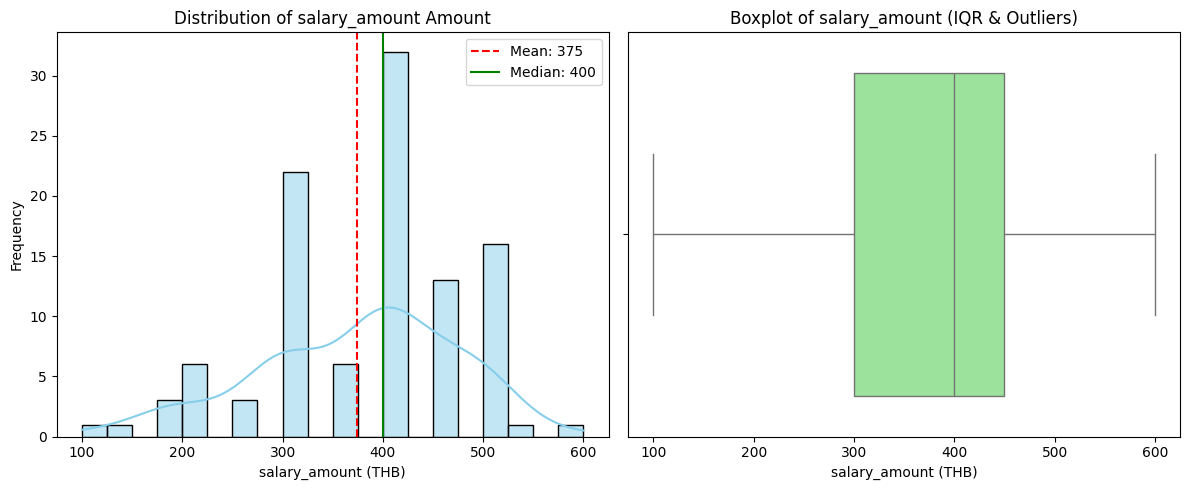

Work Type:************************************************************


work_type
Hybrid            100
On-Site            67
Work From Home     17
Name: count, dtype: int64

In [97]:
print("Position Title Counts:" + "*" *60)
print(df['position_title'].value_counts())
print("Ratio Student Draft:" + "*" *60)
log_data_stats(df, column_name='student_draft_ratio')
print("Salary:" + "*" *60)
log_data_stats(df, column_name='salary_amount')
print("Work Type:" + "*" *60)
df['work_type'].value_counts()

In [116]:
mask = (df['student_draft_ratio'] < 2.0) & \
       (df['salary_amount'] > 200.0) & (df['salary_amount'] < 500.0) & \
       (df['work_type'] != 'Work From Home')

filtered_df = df[mask]
print(df.shape, filtered_df.shape)
listNamePosition = filtered_df['position_title'].unique().tolist()
print(listNamePosition)

(206, 17) (37, 17)
['Software QA', 'Data Scientist - NLP', 'Full Stack Developer ', 'Full Stack Developer', 'Front-End Developer', 'Full-Stack Developer Intern (Urban Data Visualization + AI integration) สำหรับนิสิตปี 3 + สหกิจศึกษา', 'Software developers', 'Fullstack developer ', 'Data science', 'Junior Software Development', 'Microsoft Azure AI Developer', 'Tester', 'Application Developer Internship (Operation Improvement)', 'Full Stack Developer Internship (Procurement Systems)', 'Full-Stack Developer (ฝึกงานที่ Zettasoft พระราม3)', 'ERP Solution Development Internship', 'Full-Stack Developer ', 'Full stack Developer', 'Software Engineer', 'Warehouse Operations Excellence Intern (SQL) - Bangna KM.23 ', 'Warehouse Operations Excellence Intern (SQL) - Wangnoi Ayutthaya ', 'Data Engineer', 'Software Developer', 'Data Analyst', 'Data Management', 'Business Analyst', 'IOT Engineer', 'UX/UI Designer', 'Software Tester', 'Internship Program 2026 (นักศึกษาฝึกงาน)', 'Head Disc Mechanical Int